# Credit Risk and Default Prediction  
**Author:** Joshua Gunning  
**Course:** UC Berkeley | ECON 148 — Data Science for Economists  
**Instructor:** Rohan Jha  

## Introduction  
Understanding when borrowers are likely to repay their loans—or default—is essential to managing financial risk. During my coursework in economics and data science, I explored survival analysis as a tool to model **credit risk** and **customer churn**, focusing on the **timing** of repayment behavior rather than just whether repayment occurs.

This project applies the **Kaplan-Meier estimator** to real-world datasets in order to visualize and quantify loan survival. Using Python's `lifelines` package, I analyze two datasets:
- A **telecommunications churn dataset** from [**Kaggle**](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  
- A **German credit dataset** from the [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data)

In these contexts, **churn** (see definition [**here**](https://en.wikipedia.org/wiki/Churn_rate)) or default is treated as the key event of interest. Survival analysis lets us estimate how long it takes for these events to occur across different types of borrowers.

Throughout this notebook, I walk through the foundations of survival analysis, apply Kaplan-Meier modeling to each dataset, and interpret repayment behavior across subgroups. I also calculate **median survival times** to provide a more concrete view of repayment durations and conclude with a summary of key insights.

## Project Objectives  
- **Conceptual Overview**: Introduce survival and hazard function concepts  
- **Data Preparation**: Clean and format the datasets for modeling  
- **Kaplan-Meier Estimation**: Model loan repayment and customer churn over time  
- **Group Comparisons**: Examine how features like credit history and phone ownership affect repayment behavior  
- **Survival Metrics**: Quantify median repayment durations and summarize trends across groups  

<hr style="border: 1px solid #fdb515;" />

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
pd.set_option('display.max_columns', None)

### Conceptual Background: What is Survival Analysis?

**Survival analysis** is a set of statistical methods used to study the time until a particular event happens. In medicine, it might measure how long patients survive after treatment. In business, it’s used to measure how long customers stay before leaving a service — known as **churn**.

In finance, we use it to estimate **when** a borrower will repay a loan (or default), not just **if** they will. This time-based perspective gives lenders deeper insights into credit risk and repayment behavior.

Two core ideas in survival analysis:
- **CDF (Cumulative Distribution Function):** The probability the event *has already happened* by a certain time.
- **Survival Function:** The opposite — the probability the event *has not happened yet* by a certain time.

For example:
- If a borrower has a 70% survival probability at month 12, that means there’s a 70% chance they haven’t repaid or defaulted yet at that time.

We estimate this using the **Kaplan-Meier estimator**, a tool that builds a survival curve based on real data. It helps us visualize how risk unfolds over time — whether we're modeling customer loyalty or loan repayment behavior.
<hr style="border: 1px solid #fdb515;" />

### A Simple Example: Kaplan-Meier on Sample Data

Before we apply survival analysis to real-world financial or customer data, let’s first understand how it works with a small, made-up example.

Here’s a simple dataset that records how long a few individuals "survived" (e.g., stayed subscribed or held a loan), and whether they experienced the event (like leaving a service or repaying a loan) during the observation period.

In [31]:
# Example Data
# how long did they survive?
sample_durations = [5, 6, 6, 2.5, 4, 4]

# did they leave within the observation period?
sample_event_observed = [1, 0, 0, 1, 1, 1]

Now we’ll use the Kaplan-Meier estimator to plot a survival curve based on this data:

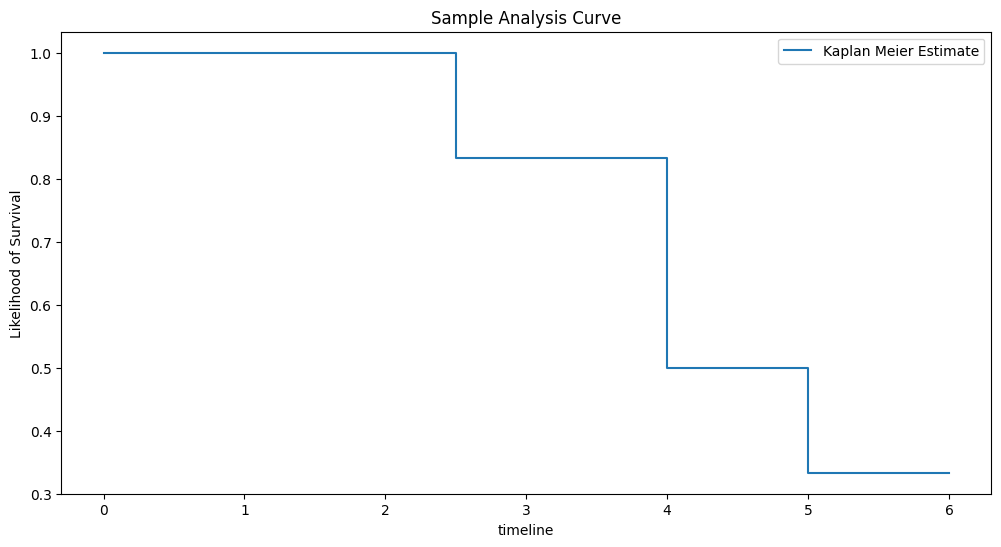

In [5]:
# create a kmf object
kmf = KaplanMeierFitter()

# Fit the data into the model
kmf.fit(sample_durations, sample_event_observed, label='Kaplan Meier Estimate')

# Create an estimate
kmf.plot(ci_show=False)
plt.title('Sample Analysis Curve')
plt.ylabel('Likelihood of Survival');


This curve helps visualize the proportion of individuals who have not experienced the event by a given time. For instance, a drop in the curve means some individuals "left" or "defaulted" at that point.

Now that we’ve seen how this works with basic data, let’s apply survival analysis to real datasets involving customer churn and credit risk.

### Data Processing
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

To analyze credit risk and customer churn using survival analysis, we’ll first need to load and clean our datasets. This section focuses on preparing two real-world datasets:

- The **Telco Customer Churn** dataset, which includes information about telecom customers and whether they discontinued service (churned).
- The **German Credit Risk** dataset, which includes demographic and financial details about borrowers, along with whether they fully repaid a loan.

Cleaning the data is a crucial first step. We’ll:
- Load the CSV files into dataframes
- Handle missing values and incorrect data types
- Convert categorical values (like "Yes"/"No") into numeric ones
- Create the time and event columns needed for Kaplan-Meier survival modeling

### Telco Customer Churn Dataset

The first dataset we'll analyze looks at customer churn for a telecommunications company.  
**Churn** refers to customers who left the service within the last month — this is the event we'll track over time.

The dataset includes:
- Customer service information (e.g., internet service, contract type, tech support)
- Demographic information (e.g., gender, senior status, partner/dependent status)
- Account information (e.g., tenure, charges, and churn status)

We’ll begin by loading the dataset and inspecting the first few rows.

In [8]:
telco = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Next, we check the data types to identify any columns that need conversion for analysis:

In [9]:
telco.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

A few issues we need to fix before modeling:
- The `Churn` column has "Yes"/"No" values which need to be converted to `1` and `0`
- The `TotalCharges` column is stored as text (`object`), but it should be numeric
- Some values in `TotalCharges` are missing and need to be filled

Let’s address these issues now.

In [16]:
telco['Churn'] = telco['Churn'].replace({'No': 0, 'Yes': 1}).astype(int)

telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'], errors='coerce')

telco['TotalCharges'] = telco['TotalCharges'].fillna(telco['TotalCharges'].median())

telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


Now that the data is cleaned, let’s use the **Kaplan-Meier estimator** to analyze how long customers tend to stay before churning. We'll define:
- `tenure` as the duration of observation (in months)
- `Churn` as the event indicator (1 = churned, 0 = still subscribed)

We'll also mark a red dashed line at 𝑡 = 30 to interpret the survival probability at that point.

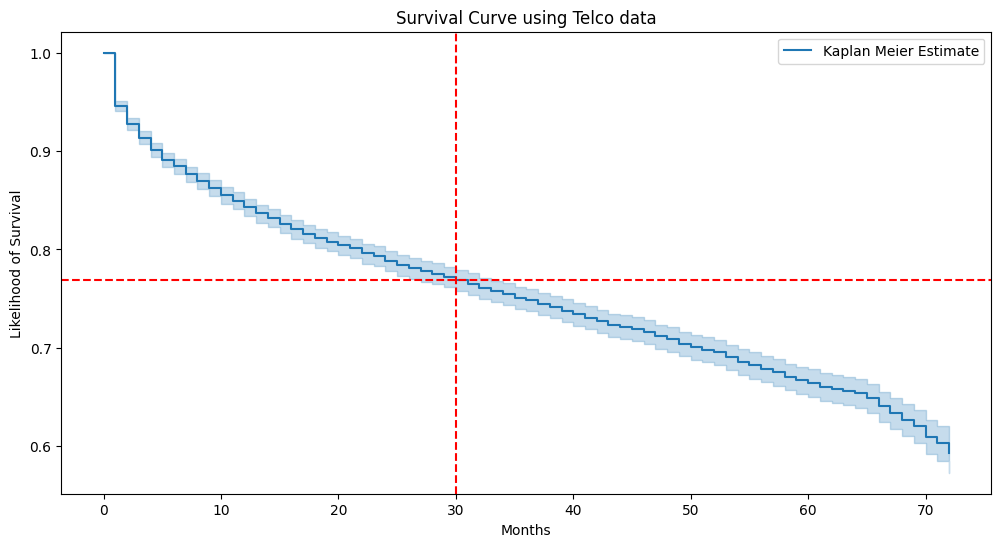

In [18]:
telco_durations = telco['tenure']
telco_event_observed = telco['Churn']

km = KaplanMeierFitter()
km.fit(telco_durations, telco_event_observed, label='Kaplan Meier Estimate')

km.plot()
plt.axhline(km.survival_function_at_times(30).item(), color="red", linestyle='dashed')
plt.axvline(30, color="red", linestyle='dashed')
plt.title('Survival Curve using Telco data')
plt.ylabel('Likelihood of Survival')
plt.xlabel('Months');

This survival curve shows the likelihood that a customer has **not churned** by each month of their subscription.

At the 30-month mark (shown with a red dashed vertical line), the horizontal dashed line represents the corresponding survival probability — about **76%**.  
This means that approximately **76% of customers stay subscribed for at least 30 months**.

The curve declines over time, indicating that the longer a customer has been with the company, the more likely they are to eventually leave — but many still remain subscribed well past two years.
<hr style="border: 1px solid #fdb515;" />

### Credit Risk Dataset

Now let’s explore another real-world application of survival analysis: **credit risk**.

Credit risk refers to the likelihood that a borrower won’t be able to repay a loan. Rather than only predicting **whether** a borrower defaults, survival analysis lets us model **when** repayment (or default) occurs. This is powerful in finance, where timing can affect interest income, collections, and risk exposure.

We’ll analyze a dataset from the [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) that includes financial and demographic data for loan applicants. The goal is to estimate the time until full loan repayment.

The key columns are:
- **`duration`**: how many months the loan lasted (our time variable)
- **`full_repaid`**: whether the loan was fully repaid (1) or not (0) — this is our event


In [20]:
credit = pd.read_csv("credit_risk.csv")
credit.head()

,checking_account_status,duration,credit_history,purpose,amount,savings_account_status,employment_years,installment_rate,personal_status,other_debtors,present_residence,property,age,other_installment_plans,housing,number_of_credits,job,people_liable,telephone,foreign_worker,full_repaid
0,below_0,6,critical_account,radio_TV,1169,unknown,above_7,4,M_single,NaN,4,real_estate,67,NaN,own,2,official,1,1,1,1
1,0_to_200,48,existing_credit_paid,radio_TV,5951,below_100,between_1_4,2,F_not_single,NaN,2,real_estate,22,NaN,own,1,official,1,0,1,0
2,no_account,12,critical_account,education,2096,below_100,between_4_7,2,M_single,NaN,3,real_estate,49,NaN,own,1,unskilled,2,0,1,1
3,below_0,42,existing_credit_paid,furniture_equipment,7882,below_100,between_4_7,2,M_single,guarantor,4,life_insurance,45,NaN,free,1,official,2,0,1,1
4,below_0,24,delay_in_paying,car_new,4870,below_100,between_1_4,3,M_single,NaN,4,no_property,53,NaN,free,2,official,2,0,1,0


The dataset includes a mix of financial, demographic, and behavioral variables:

| Feature Category     | Feature Name        | Description                                       |
|----------------------|---------------------|---------------------------------------------------|
| Time                 | `duration`          | Duration of the loan in months                    |
| Event                | `full_repaid`       | 1 = loan fully repaid, 0 = not repaid             |
| Credit Behavior      | `credit_history`    | Past credit performance                           |
| Socio-Demographics   | `age`, `telephone`  | Borrower's age and phone ownership (`1` = yes)    |
| Residential Stability| `present_residence` | Years lived at current address                    |

With the dataset now loaded, we’ll start by plotting an overall survival curve to get a sense of general repayment patterns. This will serve as a foundation before we break things down by individual borrower characteristics.

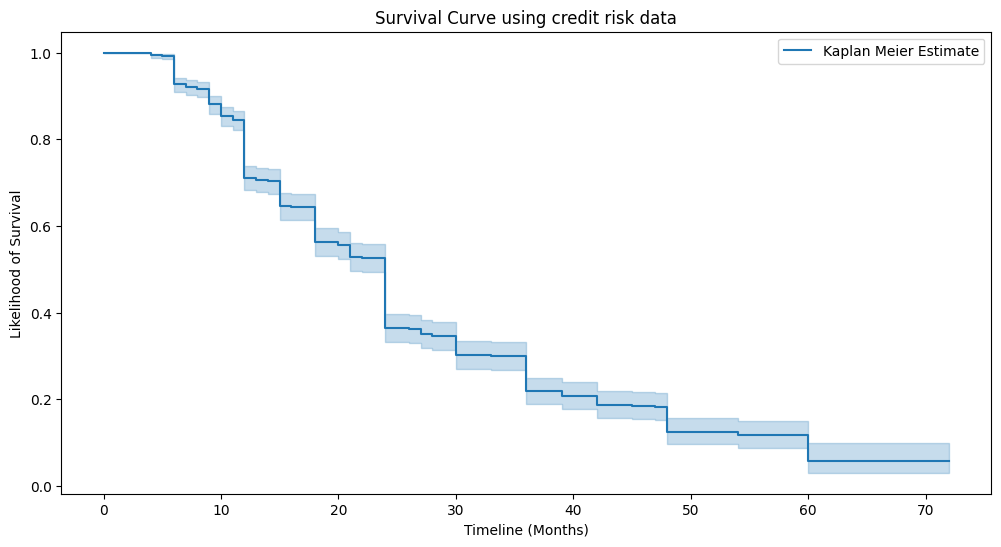

In [23]:
credit_durations = credit['duration']
credit_event_observed = credit['full_repaid']

km = KaplanMeierFitter()
km.fit(credit_durations, credit_event_observed, label='Kaplan Meier Estimate')

km.plot()
plt.title('Survival Curve using credit risk data')
plt.ylabel('Likelihood of Survival')
plt.xlabel('Timeline (Months)');

This curve reflects how long loans tend to remain unpaid — essentially, the "survival" of the debt. Ideally, borrowers with strong credit profiles would repay their loans sooner, resulting in a steeper drop in the curve early on.

### Exploring Key Features and Group Differences
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

With the baseline survival curves in place, we now turn to specific features in the dataset to see how different borrower characteristics influence repayment behavior.

We'll start by examining how **credit history** affects loan survival, followed by other factors such as **telephone ownership**. By comparing survival curves across these subgroups, we can identify patterns and better understand what traits are associated with faster or slower repayment.

### Credit History

We’ll begin by exploring how a borrower’s credit history influences loan repayment behavior. This variable captures past repayment patterns and can be a strong indicator of future risk.

To start, we’ll examine the distribution of values in the `credit_history` column to understand the most common categories before comparing their survival curves.

In [24]:
credit["credit_history"].value_counts()

credit_history
existing_credit_paid    530
critical_account        293
delay_in_paying          88
all_credit_paid          49
no_credit_taken          40
Name: count, dtype: int64

The `credit_history` column includes five different categories. To keep the analysis clear and focused, we’ll examine the three most common:

- `existing_credit_paid`: borrower has a history of timely payments  
- `critical_account`: borrower has existing or problematic credit  
- `delay_in_paying`: borrower has previously delayed repayment  

We’ll compare survival curves across these groups to see how credit background impacts repayment behavior.

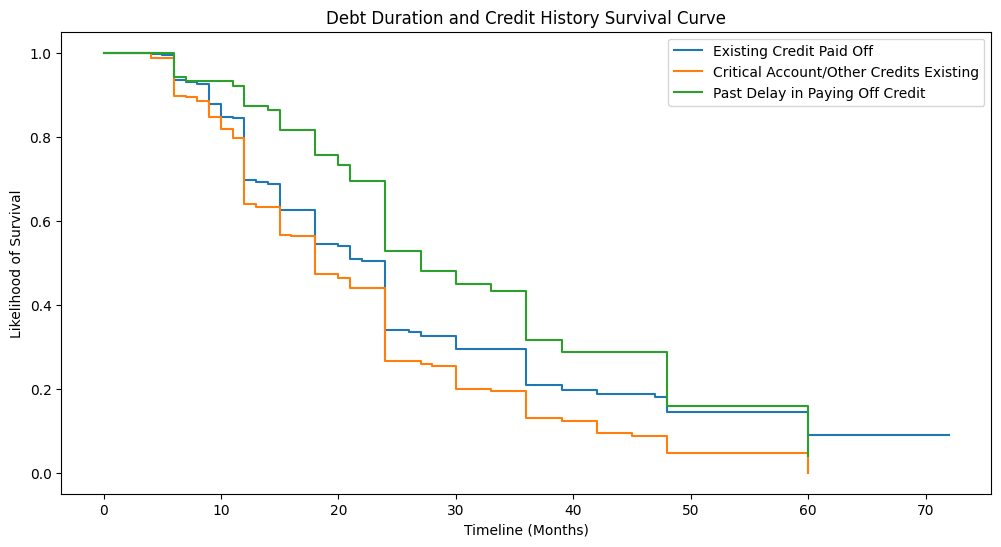

In [25]:
# Group 1: existing_credit_paid
kmf_ch1 = KaplanMeierFitter()
T1 = credit[credit['credit_history'] == 'existing_credit_paid']['duration']
E1 = credit[credit['credit_history'] == 'existing_credit_paid']['full_repaid']
kmf_ch1.fit(T1, E1, label='Existing Credit Paid Off')
ax = kmf_ch1.plot(ci_show=False)

# Group 2: critical_account
kmf_ch2 = KaplanMeierFitter()
T2 = credit[credit['credit_history'] == 'critical_account']['duration']
E2 = credit[credit['credit_history'] == 'critical_account']['full_repaid']
kmf_ch2.fit(T2, E2, label='Critical Account/Other Credits Existing')
ax = kmf_ch2.plot(ci_show=False)

# Group 3: delay_in_paying
kmf_ch3 = KaplanMeierFitter()
T3 = credit[credit['credit_history'] == 'delay_in_paying']['duration']
E3 = credit[credit['credit_history'] == 'delay_in_paying']['full_repaid']
kmf_ch3.fit(T3, E3, label='Past Delay in Paying Off Credit')
ax = kmf_ch3.plot(ci_show=False)

plt.title("Debt Duration and Credit History Survival Curve")
plt.ylabel("Likelihood of Survival")
plt.xlabel("Timeline (Months)");


The plot shows clear differences in repayment behavior across credit history categories:

- Borrowers with **existing credit paid** have moderately strong repayment behavior, with a gradual decline in their survival curve.
- Those with a **critical account** show a faster drop-off, indicating they are more likely to stop repayment earlier.
- Interestingly, borrowers with a **past delay in paying** have the slowest decline — suggesting they may take longer to repay, but don’t default as quickly.

This may reflect that while these individuals have previously delayed payments, they still eventually repay — potentially under structured repayment plans or with additional support.
<hr style="border: 1px solid #fdb515;" />

### Telephone Ownership

Next, we examine how owning a telephone influences repayment behavior. The `telephone` column is binary, where `1` means the borrower owns a phone and `0` means they don’t.

We’ll use this feature to compare repayment survival curves between these two groups.

In [26]:
credit["telephone"].value_counts()

telephone
0    596
1    404
Name: count, dtype: int64

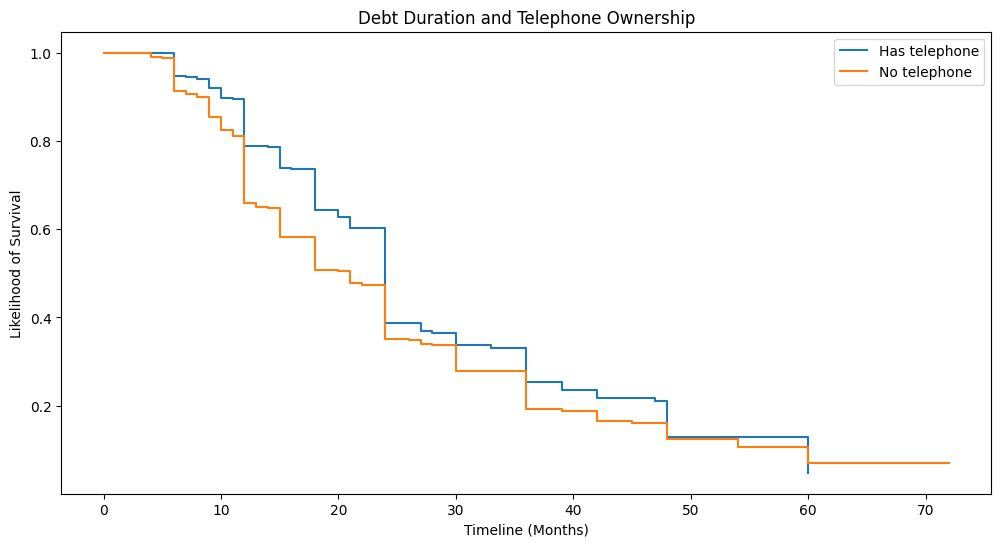

In [27]:
# Group 1: Has telephone
kmf_has_phones = KaplanMeierFitter()
TP1 = credit[credit['telephone'] == 1]['duration']
E1 = credit[credit['telephone'] == 1]['full_repaid']
kmf_has_phones.fit(TP1, E1, label='Has telephone')
ax = kmf_has_phones.plot(ci_show=False)

# Group 2: No telephone
kmf_no_phones = KaplanMeierFitter()
TP2 = credit[credit['telephone'] == 0]['duration']
E2 = credit[credit['telephone'] == 0]['full_repaid']
kmf_no_phones.fit(TP2, E2, label='No telephone')
ax = kmf_no_phones.plot(ci_show=False)

plt.title("Debt Duration and Telephone Ownership")
plt.ylabel("Likelihood of Survival")
plt.xlabel("Timeline (Months)");


The survival curves suggest that borrowers who **own a telephone** tend to repay their loans more slowly than those who do not. This might seem counterintuitive at first, but several factors could explain this trend:

- Owning a phone provides easier access to communication with lenders, which may lead to **extended repayment plans** or **negotiation opportunities**.
- A telephone bill is an additional recurring expense, which could contribute to **slower repayment capacity**.
- Borrowers without phones may be under stricter financial constraints, encouraging quicker repayment to avoid penalties or loss of future borrowing opportunities.

Overall, this highlights how even seemingly unrelated variables can reflect deeper financial behaviors in survival analysis.

### Survival Time Insights and Summary
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

Beyond visualizing survival curves, it’s important to quantify repayment behavior using summary statistics. In this section, we focus on the **median survival time** — the point at which 50% of borrowers have completed repayment — to better understand how long loans typically remain active for different borrower groups.

We also interpret these durations in the context of each feature and present a visual summary table to highlight key takeaways across subgroups. This helps translate patterns from the plots into actionable insights.

### Calculating Median Repayment Durations

To complement the survival curves, we calculate the median time it takes borrowers to fully repay their loans across different groups. This gives us a direct comparison of typical repayment timelines.

In [30]:
# Median durations by credit history
med_existing = kmf_ch1.median_survival_time_
med_critical = kmf_ch2.median_survival_time_
med_delayed = kmf_ch3.median_survival_time_

print("Median duration (existing_credit_paid):", med_existing)
print("Median duration (critical_account):", med_critical)
print("Median duration (delay_in_paying):", med_delayed)

# Median durations by phone ownership
med_phone = kmf_has_phones.median_survival_time_
med_nophone = kmf_no_phones.median_survival_time_

print("Median duration (has phone):", med_phone)
print("Median duration (no phone):", med_nophone)

Median duration (existing_credit_paid): 24.0
Median duration (critical_account): 18.0
Median duration (delay_in_paying): 27.0
Median duration (has phone): 24.0
Median duration (no phone): 21.0


### Feature-Based Summary Table

| Feature             | Group                      | Median Duration (Months) | Interpretation                                      |
|---------------------|----------------------------|---------------------------|-----------------------------------------------------|
| Credit History       | Existing Credit Paid       | 24                        | Steady repayment behavior                           |
|                      | Critical Account           | 18                        | Earlier repayment or higher early default risk      |
|                      | Delay in Paying            | 27                        | Longest timeline, but eventual repayment            |
| Telephone Ownership  | Has Telephone              | 24                        | Slower repayment, possibly due to negotiation       |
|                      | No Telephone               | 21                        | Faster repayment, possibly fewer financial levers   |

The median survival times give us a clearer view of how long borrowers typically take to repay their loans:

- Borrowers with **existing credit paid** tend to repay in about **24 months**, showing steady repayment behavior.
- Those with **critical accounts** repay sooner, at around **18 months**, which may reflect earlier default or quick resolution.
- Borrowers with **past delays in payment** actually show the longest repayment period at **27 months**, indicating that while they may repay slowly, they still tend to follow through over time.

As for telephone ownership:
- Borrowers who **own a phone** have a median repayment time of **24 months**, slightly slower than those who don’t.
- Those **without a phone** repay a bit faster, with a median of **21 months**, possibly due to tighter financial constraints or fewer opportunities to renegotiate payment terms.
<hr style="border: 1px solid #fdb515;" />

### Final Insights

This project applied survival analysis to understand patterns in credit risk and loan repayment behavior using real-world financial data.

Key takeaways include:

- **Credit history is strongly tied to repayment behavior.** Borrowers with clean histories repaid at a steady rate, while those with critical accounts tended to default or repay earlier. Interestingly, those with delayed payments often took the longest to repay, but still showed follow-through over time.
  
- **Seemingly unrelated features, like telephone ownership, revealed subtle financial dynamics.** Borrowers with phones repaid more slowly on average — potentially due to greater access to negotiation, or because phones represent added financial burden.

- **Median survival times** provided concrete metrics to compare repayment timelines across subgroups, adding clarity beyond the visual trends in the survival curves.

By translating time-to-event data into visual and quantitative insights, survival analysis offers a powerful lens for understanding repayment behavior in lending scenarios.
